In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models
from dataset import FacialKeypointsDataset
import cv2
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import config
import utils

In [53]:

# constant paths
ROOT_PATH = './'
OUTPUT_PATH = './video'
TEST_PATH = './outputs/Testing-images'
# learning parameters
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 30
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# train/test split
TEST_SPLIT = 0.1
# show dataset keypoint plot
SHOW_DATASET_PLOT = True

In [48]:
import torch.nn as nn
import torch.nn.functional as F
import pretrainedmodels

class FaceKeypointResNet18(nn.Module):
    def __init__(self, pretrained, requires_grad):
        super(FaceKeypointResNet18, self).__init__()
        if pretrained == True:
            self.model = pretrainedmodels.__dict__['resnet18'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['resnet18'](pretrained=None)
        if requires_grad == True:
            for param in self.model.parameters():
                param.requires_grad = True
            print('Training intermediate layer parameters...')
        elif requires_grad == False:
            for param in self.model.parameters():
                param.requires_grad = False
            print('Freezing intermediate layer parameters...')
        # change the final layer
        self.l0 = nn.Linear(512, 136)
    def forward(self, x):
        # get the batch size only, ignore (c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        l0 = self.l0(x)
        return l0

In [61]:
model = FaceKeypointResNet18(pretrained=True, requires_grad=False).to(config.DEVICE)
model = torch.load('./outputs/traced_model_18.pth', map_location='cpu')

# Get the model state dictionary
model_state_dict = model.state_dict()

# Filter out unnecessary keys
# checkpoint = {k: v for k, v in checkpoint.items() if k in model_state_dict}

# Load the modified checkpoint
# model.load_state_dict(checkpoint, strict=False)
model.eval()
# model.half()

Freezing intermediate layer parameters...


RecursiveScriptModule(
  original_name=FaceKeypointResNet18
  (model): RecursiveScriptModule(
    original_name=ResNet
    (conv1): RecursiveScriptModule(original_name=Conv2d)
    (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveScriptModule(original_name=ReLU)
    (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
    (layer1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=BasicBlock
        (conv1): RecursiveScriptModule(original_name=Conv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
        (relu): RecursiveScriptModule(original_name=ReLU)
        (conv2): RecursiveScriptModule(original_name=Conv2d)
        (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
      )
      (1): RecursiveScriptModule(
        original_name=BasicBlock
        (conv1): RecursiveScriptModule(original_name=Conv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
     

In [50]:
def extract_mouth(image, lip , outputs):
    max_x = 0
    min_x = 0
    max_y = 0
    min_y = 0

    for i, ind in enumerate(lip):
        (x, y) = outputs[ind]
        if i == 0:
            max_x = x
            min_x = x
            max_y = y
            min_y = y

        if x > max_x:
            max_x = x
        if x < min_x:
            min_x = x
        if y > max_y:
            max_y = y
        if y < min_y:
            min_y = y
        
    img_mouth_seg = image[ int(min_y-5) : int(max_y+10), int(min_x-10) : int(max_x+10), :]
    # print("Hi Shape: " , img_mouth_seg.shape , image.shape)
    img_mouth_seg = img_mouth_seg[:,:,0:3]*255
    
    return img_mouth_seg
    

In [51]:
def measure_emotion(img_mouth_segment, template_mouth_positive, template_mouth_negative):
    img_mouth_segment = cv2.resize(img_mouth_segment, (40, 80))
    img_mouth_segment = cv2.cvtColor(img_mouth_segment, cv2.COLOR_BGR2GRAY)
    img_mouth_segment = img_mouth_segment.astype(np.uint8)
    # print(img_mouth_segment)

    # print(img_mouth_segment)
    # print(template_mouth_positive)
    
    score_positive = cv2.matchTemplate(img_mouth_segment, template_mouth_positive, cv2.TM_CCOEFF_NORMED)[0][0]
    score_negative = cv2.matchTemplate(img_mouth_segment, template_mouth_negative, cv2.TM_CCOEFF_NORMED)[0][0]


    if score_negative  > score_positive:
        return 0
    else:
        return 1
    # # print(score_positive)
    # # print(score_negative)
    # diff = score_positive - score_negative
    # # print(diff)

    # if(diff > 0):
    #     # print("Positive Emotion")
    #     return 1
    # else:
    #     # print("Negative Emotion")
    #     return 0 


In [52]:
template_mouth_positive = cv2.imread('./Results/Task 1.3/Positive-lips.jpg', cv2.IMREAD_GRAYSCALE)
template_mouth_negative = cv2.imread('./Results/Task 1.3/Negative-lips.jpg', cv2.IMREAD_GRAYSCALE)

template_mouth_positive = cv2.resize(template_mouth_positive, (40, 80))
template_mouth_negative = cv2.resize(template_mouth_negative, (40, 80))

template_mouth_positive = template_mouth_positive.astype(np.uint8)
template_mouth_negative = template_mouth_negative.astype(np.uint8)

upper_lip = [48, 49, 50, 51, 52, 53, 54, 61, 62, 63]
lower_lip = [55, 56, 57, 58, 59, 60, 64, 65, 66, 67]

lip = []
lip.extend(upper_lip)
lip.extend(lower_lip)

In [63]:
import time
# capture the webcam
cap = cv2.VideoCapture('./video/vid_02.mp4')
if (cap.isOpened() == False):
    print('Error while trying to open webcam. Plese check again...')
 
# get the frame width and height
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
# set up the save file path
save_path = f"{config.OUTPUT_PATH}/vid_keypoint_detection_R18.mp4"
# define codec and create VideoWriter object 
out = cv2.VideoWriter(f"{save_path}", 
                      cv2.VideoWriter_fourcc(*'mp4v'), 30, 
                      (frame_width, frame_height))

# Variables for FPS calculation
start_time = time.time()
frame_count = 0

while(cap.isOpened()):
#     print("Hi")
    # capture each frame of the video
    ret, frame = cap.read()
    if ret == True:
        with torch.no_grad():
            # processing_start_time = time.time()
            image = frame
            image = cv2.resize(image, (224, 224))
            orig_frame = image.copy()
            orig_h, orig_w, c = orig_frame.shape
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image / 255.0
            image = np.transpose(image, (2, 0, 1))
            image = torch.tensor(image, dtype=torch.float)
            image = image.unsqueeze(0).to(config.DEVICE)
            # print(image.shape)
            # processing_time = time.time() - processing_start_time
            # print("Processing Time" , processing_time)
            # with torch.autocast(device_type = 'cuda' , dtype = torch.float16):
                # model_start_time = time.time()
                # outputs = model(image.half())
                # model_time = time.time() - model_start_time
            # print("Model Time" , model_time)
            
            # print("Model Time" , processing_time)
            outputs = model(image)
            
            outputs = outputs.reshape(68, 2)
            outputs = outputs.detach().cpu()
            
            img_mouth_seg = extract_mouth(frame, lip, outputs)
            emotion = measure_emotion(img_mouth_seg, template_mouth_positive, template_mouth_negative)
            if emotion == 1:
                state = 'Positive'
            else:
                state = 'Negative'
            # Calculate FPS
        frame_count += 1
        elapsed_time = time.time() - start_time
        fps = frame_count / elapsed_time

        # Display the FPS on the frame
        cv2.putText(orig_frame, f'FPS: {round(fps, 2)} {state}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        # cv2.putText(orig_frame, f'FPS: {round(fps, 2)}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        outputs = outputs.cpu().detach().numpy()
        outputs = outputs.reshape(-1, 2)
        keypoints = outputs
        for p in range(keypoints.shape[0]):
            cv2.circle(orig_frame, (int(keypoints[p, 0]), int(keypoints[p, 1])),
                        1, (0, 0, 255), -1, cv2.LINE_AA)
        orig_frame = cv2.resize(orig_frame, (frame_width, frame_height))
        cv2.imshow('Facial Keypoint Frame', orig_frame)
        out.write(orig_frame)
        # press `q` to exit
        if cv2.waitKey(27) & 0xFF == ord('q'):
            break
 
    else: 
        break
        
# release VideoCapture()
cap.release()
out.release()
# close all frames and video windows
cv2.destroyAllWindows()

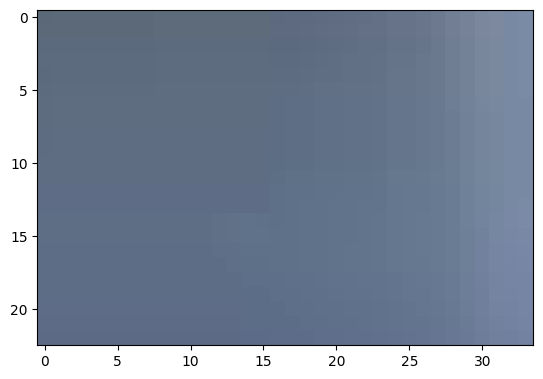

In [21]:
plt.imshow(img_mouth_seg)

# Optimization

## Quantization

In [15]:
import torch.quantization

# Load your trained model
model = FaceKeypointResNet18(pretrained=True, requires_grad=False).to(config.DEVICE)
checkpoint = torch.load('./outputs/model_18.pth', map_location='cpu')

# Get the model state dictionary
model_state_dict = model.state_dict()

# Filter out unnecessary keys
checkpoint = {k: v for k, v in checkpoint.items() if k in model_state_dict}

# Load the modified checkpoint
model.load_state_dict(checkpoint, strict=False)
# model.eval()
# model.half()

# model_op = model.load_state_dict(torch.load(model_path))

# Quantize the model
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Conv2d}, dtype=torch.qint8
)

# Save the quantized model
torch.save(model.state_dict(), f"{OUTPUT_PATH}/q_model_18.pth")

Freezing intermediate layer parameters...


## Torch Half

In [6]:
# Load your trained model
model = FaceKeypointResNet18(pretrained=True, requires_grad=False).to(config.DEVICE)
checkpoint = torch.load('./outputs/model_18.pth', map_location='cpu')

# Get the model state dictionary
model_state_dict = model.state_dict()

# Filter out unnecessary keys
checkpoint = {k: v for k, v in checkpoint.items() if k in model_state_dict}

# Load the modified checkpoint
model.load_state_dict(checkpoint, strict=False)
model.half()
model.eval()

Freezing intermediate layer parameters...


FaceKeypointResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [58]:
example_input = torch.rand(1,3,224,224).to(DEVICE)
model.eval()

traced_model = torch.jit.trace(model, example_input)

traced_model_path = f'{OUTPUT_PATH}/traced_model_18.pth'

traced_model.save(traced_model_path)

# num_params = model.parameters()
# print(f"Number of Params: {num_params}")

In [64]:
DEVICE

device(type='cuda')